In [1]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [4]:
df = pd.read_csv("SCALE불량.csv", encoding = "euc-kr")
df.head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조


In [5]:
df['scale'].unique()

array(['양품', '불량'], dtype=object)

In [6]:
df['scale'] = df['scale'].replace({'양품': 0, '불량': 1})

In [7]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# # 'hsb' 열을 숫자로 인코딩
# df['hsb'] = label_encoder.fit_transform(df['hsb']) # 1: 적용, 0 : 미적용

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   int64 
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [9]:
df['datetime'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S', errors='coerce')
df['hour'] = df['datetime'].dt.hour
df.drop(columns=["rolling_date",'fur_ex_temp','plate_no','datetime', 'spec_long'],inplace=True)
# 'hour' 변수를 문자열(object)로 변환
df['hour'] = df['hour'].astype(str)

In [10]:
percentage_by_hour = df.groupby('hour')['scale'].mean() * 100
print(percentage_by_hour)

hour
0     34.090909
1     28.571429
10    42.500000
11    46.666667
12    51.219512
13    37.500000
14    25.581395
15    25.000000
16    34.146341
17    31.111111
18    27.500000
19    16.666667
2     37.209302
20    14.634146
21    13.953488
22    29.268293
23    39.534884
3     20.930233
4     26.190476
5     31.111111
6     30.303030
7     32.500000
8     25.000000
9     43.589744
Name: scale, dtype: float64


In [11]:
# 'hour' 변수를 문자열(object)로 변환
df['hour'] = df['hour'].astype(str)

In [12]:
numeric_df = df.select_dtypes(include=['float64', 'int64']) 
numeric_df.corr()  

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
scale,1.000000,-0.098090,-0.189536,0.052115,0.222493,-0.035826,0.327817,-0.219581,-0.127695,0.375704,-0.040011
pt_thick,-0.098090,1.000000,-0.319894,-0.867125,-0.525317,0.206644,-0.665964,0.357260,0.338078,-0.363406,-0.845324
pt_width,-0.189536,-0.319894,1.000000,0.147979,0.200737,-0.100876,0.216879,-0.097273,-0.133329,-0.060320,0.350132
pt_length,0.052115,-0.867125,0.147979,1.000000,0.470846,-0.137895,0.603303,-0.333730,-0.276402,0.290828,0.818483
fur_heat_temp,0.222493,-0.525317,0.200737,0.470846,1.000000,-0.163792,0.787203,-0.373154,-0.313632,0.268803,0.488292
fur_heat_time,-0.035826,0.206644,-0.100876,-0.137895,-0.163792,1.000000,-0.349176,0.114804,0.736069,-0.083188,-0.166892
fur_soak_temp,0.327817,-0.665964,0.216879,0.603303,0.787203,-0.349176,1.000000,-0.596820,-0.560808,0.459210,0.627843
fur_soak_time,-0.219581,0.357260,-0.097273,-0.333730,-0.373154,0.114804,-0.596820,1.000000,0.632995,-0.308021,-0.399353
fur_total_time,-0.127695,0.338078,-0.133329,-0.276402,-0.313632,0.736069,-0.560808,0.632995,1.000000,-0.208733,-0.339263
rolling_temp,0.375704,-0.363406,-0.060320,0.290828,0.268803,-0.083188,0.459210,-0.308021,-0.208733,1.000000,0.250112


In [13]:
df.loc[df['rolling_temp'] >900, 'rolling_temp_>900'] = 1
df.loc[df['rolling_temp'] <=900, 'rolling_temp_>900'] = 0

df['pt_area'] = df['pt_length'] * df['pt_width']
df['fur_temp_gap'] = df['fur_heat_temp'] - df['fur_soak_temp']

df = df[df['rolling_temp'] != 0]

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaling을 적용할 수치형 변수들 선택
numeric_columns = []
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        numeric_columns.append(column)

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [15]:
df = pd.get_dummies(df, dtype=int)
df

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,0.0,0.227273,0.678571,0.153191,0.398058,0.592233,0.277778,0.218182,0.477157,0.594366,...,0,0,0,0,0,0,0,1,0,0
1,0.0,0.227273,0.678571,0.153191,0.398058,0.650485,0.305556,0.163636,0.370558,0.602817,...,0,0,0,0,0,0,0,1,0,0
2,0.0,0.238636,0.642857,0.240426,0.252427,0.592233,0.111111,0.181818,0.472081,0.467606,...,0,0,0,0,0,0,0,1,0,0
3,0.0,0.238636,0.642857,0.240426,0.475728,0.679612,0.194444,0.300000,0.512690,0.456338,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0.295455,0.464286,0.114894,0.359223,0.766990,0.208333,0.118182,0.411168,0.422535,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.079545,0.571429,0.714894,0.378641,0.000000,0.527778,0.463636,0.192893,0.633803,...,0,0,0,0,0,1,0,0,0,0
996,0.0,0.079545,0.571429,0.714894,0.378641,0.000000,0.527778,0.463636,0.223350,0.633803,...,0,0,0,0,0,1,0,0,0,0
997,0.0,0.056818,0.571429,0.761702,0.640777,0.097087,0.694444,0.381818,0.314721,0.633803,...,0,0,0,0,0,1,0,0,0,0
998,0.0,0.056818,0.571429,0.761702,0.640777,0.097087,0.694444,0.381818,0.197970,0.633803,...,0,0,0,0,0,0,1,0,0,0


In [16]:
df_raw_x = df.drop(columns="scale")
df_raw_y = df['scale']

In [17]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
                                                                , test_size = 0.3, random_state = 1234) 

In [18]:
# 135 Page
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.963


In [19]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.228
5,fur_soak_temp,0.085
9,descaling_count,0.064
1,pt_width,0.062
22,hsb_미적용,0.055
11,pt_area,0.055
3,fur_heat_temp,0.047
0,pt_thick,0.045
23,hsb_적용,0.044
2,pt_length,0.040


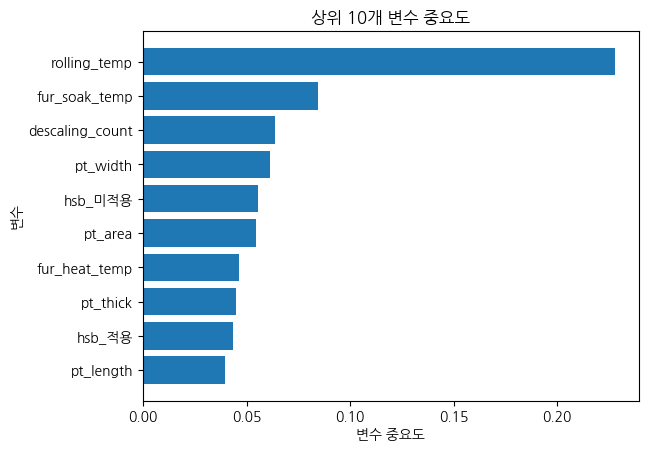

In [20]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top_10_importance = df_importance.nlargest(10, "Importance")

# 시각화
coordinates = range(len(top_10_importance))
plt.barh(y=coordinates[::-1], width=top_10_importance["Importance"])
plt.yticks(coordinates[::-1], top_10_importance["Feature"], fontsize=10)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.title("상위 10개 변수 중요도")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
estimator = RandomForestClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": [7,9,11,13,15,17],
              "n_estimators" : [200,300,400,500],
              "min_samples_split": [4,8,12,16,20],
              "min_samples_leaf": [2,4,6,8,10,12] }
# 설명력이 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

In [22]:
rf_uncustomized = RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=16,
                      random_state=1234, n_estimators =300)
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.965
Score on test set: 0.960


In [23]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.282
5,fur_soak_temp,0.087
9,descaling_count,0.065
1,pt_width,0.056
11,pt_area,0.056
22,hsb_미적용,0.054
23,hsb_적용,0.049
0,pt_thick,0.047
3,fur_heat_temp,0.046
2,pt_length,0.040


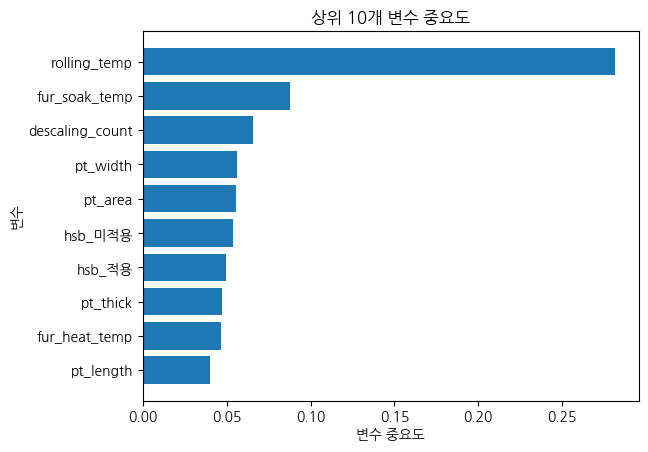

In [24]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top_10_importance = df_importance.nlargest(10, "Importance")

# 시각화
coordinates = range(len(top_10_importance))
plt.barh(y=coordinates[::-1], width=top_10_importance["Importance"])
plt.yticks(coordinates[::-1], top_10_importance["Feature"], fontsize=10)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.title("상위 10개 변수 중요도")
plt.show()